In [1]:
!pip3 install -U -q datasets transformers accelerate bitsandbytes langchain langchain-community peft wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 44.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 36.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.6/411.6 kB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 3.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec

In [73]:
import torch
from torch.utils.data import DataLoader

from sentence_transformers import SentenceTransformer, util
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline, BitsAndBytesConfig, TrainingArguments, Trainer, DataCollatorForLanguageModeling
from datasets import load_dataset

from langchain import HuggingFacePipeline
from langchain import PromptTemplate, LLMChain

from peft import LoraConfig, prepare_model_for_kbit_training, get_peft_model

from huggingface_hub import login

import wandb

import matplotlib.pyplot as plt

In [41]:
wandb.init(mode="disabled")

In [47]:
ds = load_dataset("medalpaca/medical_meadow_medical_flashcards")
print('Structure of data: ', ds)

Structure of data:  DatasetDict({
    train: Dataset({
        features: ['input', 'output', 'instruction'],
        num_rows: 33955
    })
})


The data is a dictionary ```train``` as the key and another dictionary ```Dataset```  as the value, the keys of this dictinoary are ```features``` and ```num_rows```, features being one of the ```input```, ```output```, or ```instruction```.

The ```num_rows``` suggests that there are 33955 questions and answers with instructions respectively.

Let us have a look at how each one of these are:

In [4]:
print(f'Input :', ds['train']['input'][0])
print(f'Output :', ds['train']['output'][0])
print(f'Instruction :', ds['train']['instruction'][0])

Input : What is the relationship between very low Mg2+ levels, PTH levels, and Ca2+ levels?
Output : Very low Mg2+ levels correspond to low PTH levels which in turn results in low Ca2+ levels.
Instruction : Answer this question truthfully


The ```input```'s are questions,

The ```output```'s are answers and,

The ```instruction```'s are the instructions to answer the questions.

Lowercasing the text, tokenizing based on spaces to prepare the text for training.

In [ ]:
import re
import numpy as np

tokenized_sentences = [re.sub('\W', ' ', sentence).lower().split() for sentence in ds['train']['output']]
#\W removes the non word characters thereby removing the '+','/','-' that could be good to keep
for i in tokenized_sentences[:5]:
  print(i)

print(f'Minimum sentence len: ', min([len(i)for i in tokenized_sentences]))
print(f'Maximum sentence len: ', max([len(i)for i in tokenized_sentences]))
print(f'Average sentence len: ', np.mean([len(i)for i in tokenized_sentences]))

['very', 'low', 'mg2', 'levels', 'correspond', 'to', 'low', 'pth', 'levels', 'which', 'in', 'turn', 'results', 'in', 'low', 'ca2', 'levels']
['low', 'estradiol', 'production', 'leads', 'to', 'genitourinary', 'syndrome', 'of', 'menopause', 'atrophic', 'vaginitis']
['low', 'rem', 'sleep', 'latency', 'and', 'experiencing', 'hallucinations', 'sleep', 'paralysis', 'suggests', 'narcolepsy']
['pth', 'independent', 'hypercalcemia', 'which', 'can', 'be', 'caused', 'by', 'cancer', 'granulomatous', 'disease', 'or', 'vitamin', 'd', 'intoxication']
['the', 'level', 'of', 'anti', 'müllerian', 'hormone', 'is', 'directly', 'related', 'to', 'ovarian', 'reserve', 'a', 'lower', 'level', 'indicates', 'a', 'lower', 'ovarian', 'reserve']
Minimum sentence len:  0
Maximum sentence len:  247
Average sentence len:  54.24835812104256


We now want to train the Word2Vec on the ```outputs```.

In [ ]:
from gensim.models.word2vec import Word2Vec

model = Word2Vec(tokenized_sentences, vector_size=100, min_count=2, window=10)
print(f'Learnt vectors: ',len(model.wv))

Learnt vectors:  17679


Some things to try,

try different terms

most similar words

In [ ]:
# term = 'sickness'
# term = 'fever'
# term = 'cure'
term = 'drugs'

sims = model.wv.most_similar(term, topn=5)
sims

[('agents', 0.8299513459205627),
 ('inhibitors', 0.7546903491020203),
 ('medications', 0.7247933745384216),
 ('drug', 0.7059262990951538),
 ('propranolol', 0.6731447577476501)]

Configure bits-and-bytes

Download the model and tokenizer, model as quantized

In [6]:
name = "gpt2"

In [7]:
tokenizer = AutoTokenizer.from_pretrained(name)
tokenizer.pad_token = tokenizer.eos_token

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [64]:
quantization_config = BitsAndBytesConfig(load_in_4bit=True,
                                         bnb_4bit_compute_dtype=torch.float16,
                                         bnb_4bit_quant_type="nf4",
                                         bnb_4bit_use_double_quant=True)

model = AutoModelForCausalLM.from_pretrained(name, device_map="auto",
                                             bos_token_id=tokenizer.bos_token_id,
                                             eos_token_id=tokenizer.eos_token_id,
                                             quantization_config=quantization_config)

In [65]:
model

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Linear4bit(in_features=768, out_features=2304, bias=True)
          (c_proj): Linear4bit(in_features=768, out_features=768, bias=True)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Linear4bit(in_features=768, out_features=3072, bias=True)
          (c_proj): Linear4bit(in_features=3072, out_features=768, bias=True)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_a

Format data for training

Map:   0%|          | 0/33955 [00:00<?, ? examples/s]

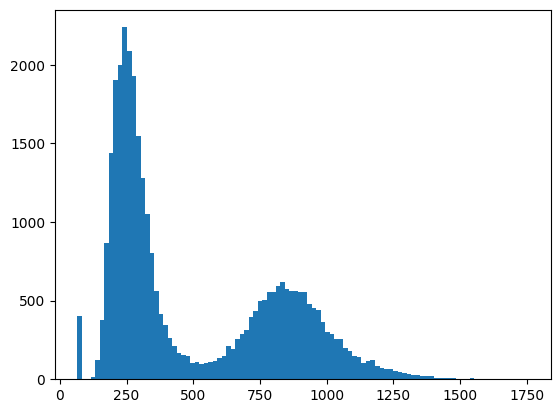

In [76]:
alpaca_prompt = """Instruction: {}

Question: {}

Answer: {}"""

def format(examples):
    instructions = examples["instruction"]
    inputs       = examples["input"]
    outputs      = examples["output"]
    texts = []
    for instruction, input, output in zip(instructions, inputs, outputs):
        text = alpaca_prompt.format(instruction, input, output)
        texts.append(text)
    return {"text": texts}

ds = ds.map(format, batched=True)

plt.hist([len(sample['text']) for sample in ds['train']], 100)
plt.show()

In [88]:
def tokenize(examples):
    inputs = tokenizer(examples["text"], truncation=True)
    inputs["label"] = inputs["input_ids"].copy()
    return inputs

ds_encoded = ds.map(tokenize, batched=True, remove_columns=ds["train"].column_names)
ds_encoded

Map:   0%|          | 0/33955 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'label'],
        num_rows: 33955
    })
})

Create LoRA configuration for QLoRA

In [90]:
adapter_configs = {
    'target_modules': 'all-linear',
    'lora_alpha': 4,
    'lora_dropout': 0.1,
    'r': 8,
    'bias': 'none',
    'task_type': 'CAUSAL_LM'
}

lora_configs = LoraConfig(**adapter_configs)

Create model

In [91]:
prepared_model_4bit = prepare_model_for_kbit_training(model)
qlora_model = get_peft_model(prepared_model_4bit, lora_configs)

In [92]:
qlora_model.print_trainable_parameters()

trainable params: 1,179,648 || all params: 125,619,456 || trainable%: 0.9391


In [102]:
train_args = TrainingArguments(
    num_train_epochs=3,
    per_device_train_batch_size=16,
    gradient_accumulation_steps=4,
    learning_rate=1e-5,
    fp16=True,
    logging_steps=16,
    output_dir="outputs",
)
trainer = Trainer(
    model=qlora_model,
    processing_class=tokenizer,
    train_dataset=ds_encoded['train'],
    args=train_args,
    data_collator=DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

In [103]:
trainer.train()

ValueError: Unable to create tensor, you should probably activate truncation and/or padding with 'padding=True' 'truncation=True' to have batched tensors with the same length. Perhaps your features (`label` in this case) have excessive nesting (inputs type `list` where type `int` is expected).

Create collat function for tokenized inputs/outputs

In [5]:
def collate(mini_batch):
    input_encodings = tokenizer([sample['text'] for sample in mini_batch], return_tensors='pt', padding=True)
    labels = input_encodings.input_ids.clone()
    labels[~input_encodings.attention_mask.bool()] = -100

    return input_encodings, labels

data_loader = DataLoader(
    ds_formatted['train'], collate_fn=collate, shuffle=True, batch_size=16
)

NameError: name 'tokenizer' is not defined

Wrap model into a PyTorch Lightning module

In [ ]:
import lightning as L
from torch.optim import AdamW
import torch.nn.functional as F

class LightningWrapper(L.LightningModule):
    def __init__(self, model, tokeniser, lr=1.e-5):
        super().__init__()
        self._model = model
        self._tokeniser = tokeniser
        self._lr = lr

    def configure_optimizers(self):
        # Build optimiser
        optimiser = AdamW(self.parameters(), lr=self._lr)

        return optimiser

    def forward(self, *args, **kwargs):
        return self._model.forward(*args, **kwargs)

    def training_step(self, mini_batch, mini_batch_idx):
        # Unpack the encoding and the target labels
        input_encodings, labels = mini_batch
        # Run generic forward step
        output = self.forward(**input_encodings)
        # Compute logits
        logits: torch.tensor = output.logits
        # Shift logits to exclude the last element
        logits = logits[..., :-1, :].contiguous()
        # shift labels to exclude the first element
        labels = labels[..., 1:].contiguous()
        # Compute LM loss token-wise
        loss: torch.tensor = F.cross_entropy(logits.view(-1, logits.size(-1)), labels.view(-1))

        return loss

lightning_model = LightningWrapper(qlora_model, tokenizer)

Training

In [ ]:
trainer = L.Trainer(
    accumulate_grad_batches=32,
    precision='bf16-mixed',  # Mixed precision (bf16-mixed or 16-mixed)
    gradient_clip_val=1.0,  # Gradient clipping
    max_epochs=1
)

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(lightning_model, train_dataloaders=data_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type                 | Params | Mode 
--------------------------------------------------------
0 | _model | PeftModelForCausalLM | 83.2 M | train
--------------------------------------------------------
1.2 M     Trainable params
82.0 M    Non-trainable params
83.2 M    Total params
332.609   Total estimated model params size (MB)
646       Modules in train mode
0         Modules in eval mode


Training: |                                              | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


In [ ]:
print(pipe("The quick brown fox jumps")[0]['generated_text'])

C:\Users\Janna-Emilia\miniconda3\envs\nlp\Lib\site-packages\transformers\generation\utils.py:2134: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cuda, whereas the model is on cpu. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cpu') before running `.generate()`.
  warnings.warn(


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument index in method wrapper_CUDA__index_select)